- [10.3.2 - Hierarchical MCMC computation of relative model probability (Two factories of coins)](#10.3.2---Hierarchical-MCMC-computation-of-relative-model-probability)
 - [Model 1 - One theta variable ](#Model-1---One-theta-variable)
 - [Model 2 - Two theta variables without pseudo priors](#Model-2---Two-theta-variables-without-pseudo-priors)
 - [Model 3 - Two theta variables with pseudo priors = true prior](#Model-3---Two-theta-variables-with-pseudo-priors-=-true-prior)
 - [Model 4 - Two theta variables with pseudo priors that mimic posteriors ](#Model-4---Two-theta-variables-with-pseudo-priors-that-mimic-posteriors)

## Chapter 10 - Model Comparision and Hierarchical Modelling

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode
from theano.tensor import eq
from sklearn import preprocessing
from IPython.display import Image
from matplotlib import gridspec

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_rows', 45)

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

### 10.3.2 - Hierarchical MCMC computation of relative model probability

#### Model (Kruschke, 2015)

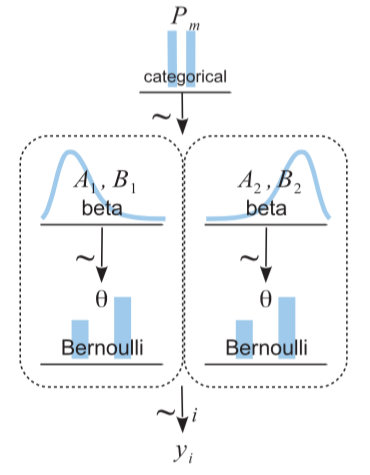

In [2]:
Image('images/fig10_2.png', width=300)

### Model 1 - One theta variable 
Coin is flipped nine times, resulting in six heads.

In [3]:
with pmc.Model() as hierarchical_model:
    m = pmc.Categorical('m', np.asarray([.5, .5]))
    
    kappa = 12
    
    omega = pmc.switch(eq(m, 0), .25, .75)
    
    theta = pmc.Beta('theta', omega*(kappa-2)+1, (1-omega)*(kappa-2)+1)
    
    y = pmc.Bernoulli('y', theta, observed=[1,1,1,1,1,1,0,0,0])    

Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [4]:
with hierarchical_model:
    step = pmc.NUTS()
     
    trace = pmc.sample(15000, step)

Assigned BinaryGibbsMetropolis to m
 [-----------------100%-----------------] 15000 of 15000 complete in 6.9 sec

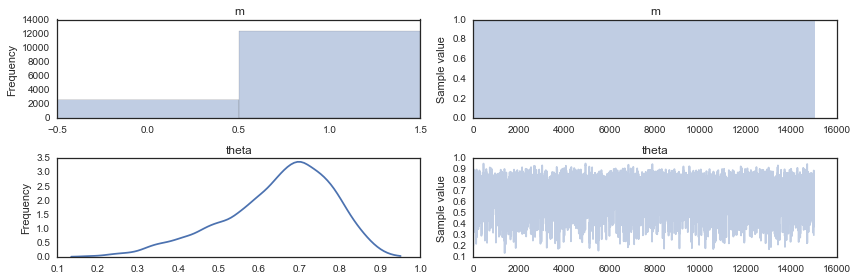

In [5]:
pmc.traceplot(trace);

Because the trace contains just one $\theta$ variable, the function *plot_posterior()* cannot be used to visualize the posterior distribution of $\theta$ when $m=0$ and $m=1$. You cannot pass it an array with just the $\theta$ values for $m=0$ either. Instead, we can put the trace in a dataframe, index by $m$, calculate the modes and create a plot ourselves.

In [6]:
trace_df = (pmc.trace_to_dataframe(trace)
            .set_index('m')
            .drop('theta_logodds_', axis=1))
trace_df.head()

      theta
m          
0  0.202878
0  0.202878
1  0.543558
1  0.835478
1  0.856044

In [7]:
# modes per category m
mode_df = trace_df.groupby(level=0).apply(lambda x: mode(np.round(x, decimals=3))[0][0])
mode_df

m
0    [0.401]
1    [0.706]
dtype: object

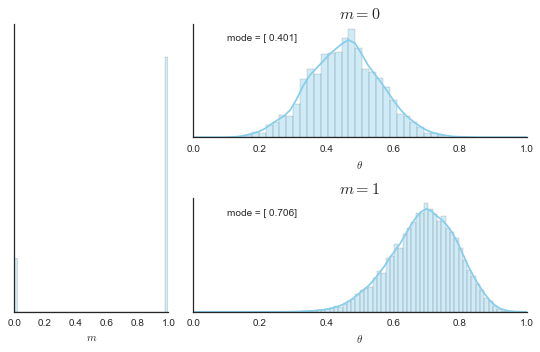

In [8]:
plt.figure(figsize=(10,5))

font_d = {'size':16}

# Define gridspec
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0:,1])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,2:])

# Distplot m
sns.distplot(trace_df.index, kde=False, ax=ax1, axlabel=r'$m$', color=color)
ax1.yaxis.set_visible(False)
ax1.spines['bottom'].set_visible(False)
sns.despine(ax=ax1)

# Distplot theta (m=0)
sns.distplot(trace_df.loc[0], ax = ax2, color=color)
ax2.set_title(r'$m = 0$', fontdict=font_d)
ax2.text(0.1, 0.85, 'mode = {}'.format(mode_df.loc[0]), transform=ax2.transAxes)

# Distplot theta (m=1)
sns.distplot(trace_df.loc[1], ax = ax3, color=color)
ax3.set_title(r'$m = 1$', fontdict=font_d)
ax3.text(0.1, 0.85, 'mode = {}'.format(mode_df.loc[1]), transform=ax3.transAxes)

for ax in [ax2, ax3]:
    ax.set(xlim=(0,1), xlabel=r'$\theta$')
    ax.yaxis.set_visible(False)
    sns.despine(ax=ax)

plt.tight_layout();

### Model 2 - Two theta variables without pseudo priors
Coin is flipped nine times, resulting in six heads.

In [9]:
with pmc.Model() as hierarchical_model2:
    m = pmc.Categorical('m', np.asarray([.5, .5]))
    
    omega_0 = .25
    kappa_0 = 12
    theta_0 = pmc.Beta('theta_0', omega_0*(kappa_0-2)+1, (1-omega_0)*(kappa_0-2)+1)
    
    omega_1 = .75
    kappa_1 = 12
    theta_1 = pmc.Beta('theta_1', omega_1*(kappa_1-2)+1, (1-omega_1)*(kappa_1-2)+1)
    
    theta = pmc.switch(eq(m, 0), theta_0, theta_1)
    
    y2 = pmc.Bernoulli('y2', theta, observed=[1,1,1,1,1,0,0,0])    

Applied logodds-transform to theta_0 and added transformed theta_0_logodds_ to model.
Applied logodds-transform to theta_1 and added transformed theta_1_logodds_ to model.


In [10]:
with hierarchical_model2:
    step = pmc.NUTS()
     
    trace2 = pmc.sample(15000, step)

Assigned BinaryGibbsMetropolis to m
 [-----------------100%-----------------] 15000 of 15000 complete in 9.8 sec

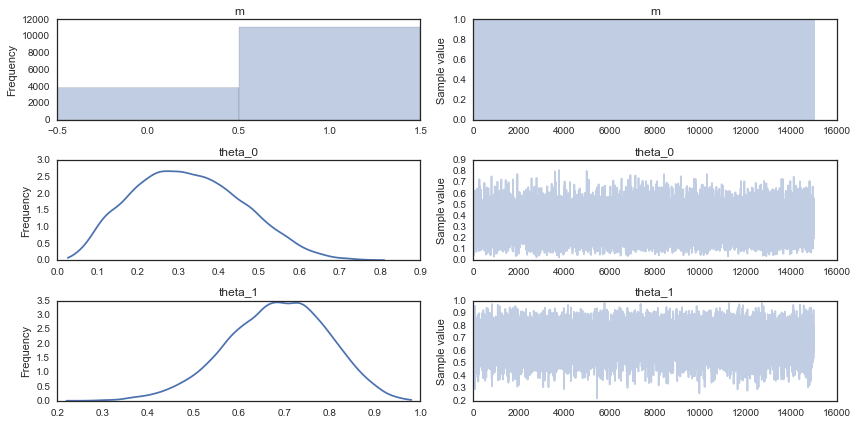

In [11]:
pmc.traceplot(trace2);

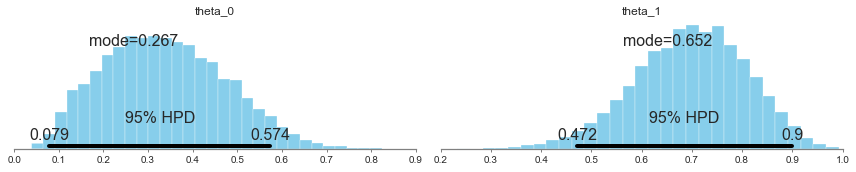

In [12]:
pmc.plot_posterior(trace2, varnames=['theta_0', 'theta_1'], point_estimate='mode', color=color);

### Model 3 - Two theta variables with pseudo priors = true prior
Coin is flipped 30 times, resulting in 17 heads.

In [13]:
with pmc.Model() as hierarchical_model3:
    m = pmc.Categorical('m', np.asarray([.5, .5]))
    
    # Theta0
    kappa_0_true_p = 20
    kappa_0_pseudo_p = 20
    kappa_0 = pmc.switch(eq(m, 0), kappa_0_true_p, kappa_0_pseudo_p)
    omega_0_true_p = .10
    omega_0_pseudo_p = .10
    omega_0 = pmc.switch(eq(m, 0), omega_0_true_p, omega_0_pseudo_p)
    theta_0 = pmc.Beta('theta_0', omega_0*(kappa_0-2)+1, (1-omega_0)*(kappa_0-2)+1)
    
    # Theta1    
    kappa_1_true_p = 20
    kappa_1_pseudo_p = 20 
    kappa_1 = pmc.switch(eq(m, 1), kappa_1_true_p, kappa_1_pseudo_p)
    omega_1_true_p = .90
    omega_1_pseudo_p = .90
    omega_1 = pmc.switch(eq(m, 1), omega_1_true_p, omega_1_pseudo_p)
    theta_1 = pmc.Beta('theta_1', omega_1*(kappa_1-2)+1, (1-omega_1)*(kappa_1-2)+1)
    
    theta = pmc.switch(eq(m, 0), theta_0, theta_1)
    
    y3 = pmc.Bernoulli('y3', theta, observed=np.r_[17*[1], 13*[0]])

Applied logodds-transform to theta_0 and added transformed theta_0_logodds_ to model.
Applied logodds-transform to theta_1 and added transformed theta_1_logodds_ to model.


In [14]:
with hierarchical_model3:
    step = pmc.NUTS()
     
    trace3 = pmc.sample(15000, step)

Assigned BinaryGibbsMetropolis to m
 [-----------------100%-----------------] 15000 of 15000 complete in 11.5 sec

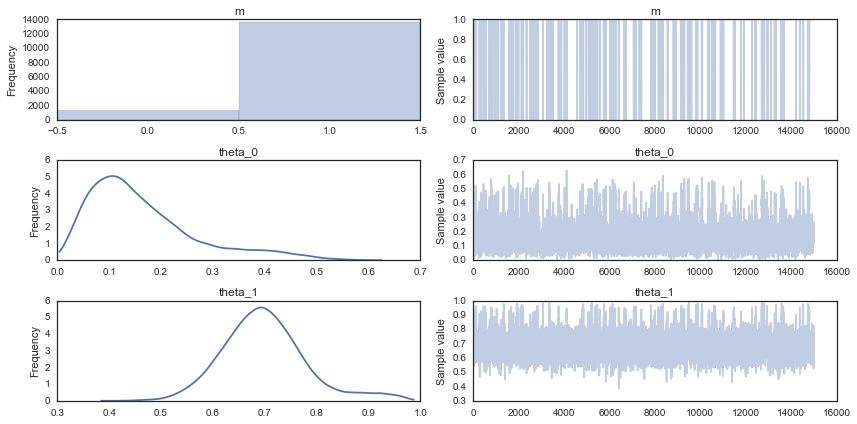

In [15]:
pmc.traceplot(trace3);

In model 3 and 4 we have two theta variables. But if we want to see the posterior distributions when using true or pseudo priors for each of them, we need to make the plot ourselves again.

In [16]:
trace3_df = (pmc.trace_to_dataframe(trace3)
            .set_index('m')
            .iloc[:,:2])
trace3_df.head()

    theta_1   theta_0
m                    
1  0.744010  0.415441
0  0.744010  0.415441
0  0.927483  0.405722
0  0.914560  0.337742
0  0.914560  0.337742

In [17]:
# modes per category m
mode3_df = trace3_df.groupby(level=0).apply(lambda x: mode(np.round(x, decimals=3))[0][0])
mode3_df

m
0    [0.934, 0.379]
1     [0.69, 0.114]
dtype: object

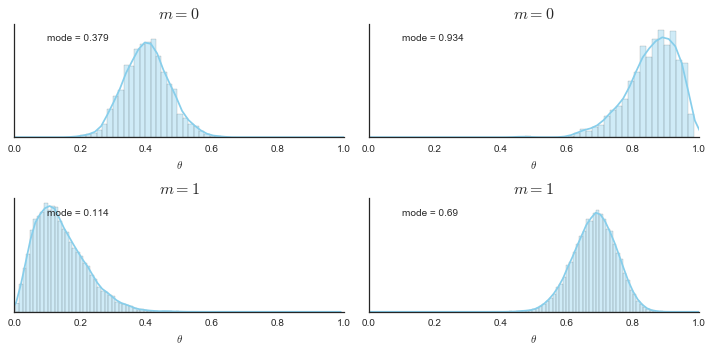

In [18]:
plt.figure(figsize=(10,5))

font_d = {'size':16}

# Define gridspec
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])

# Distplot theta0 when m = 0 (true prior)
sns.distplot(trace3_df.loc[0, 'theta_0'], ax = ax1, color=color)
ax1.set_title(r'$m = 0$', fontdict=font_d)
ax1.text(0.1, 0.85, 'mode = {}'.format(mode3_df.loc[0][1]), transform=ax1.transAxes)

# Distplot theta1 when m = 0 (pseudo prior)
sns.distplot(trace3_df.loc[0, 'theta_1'], ax = ax2, color=color)
ax2.set_title(r'$m = 0$', fontdict=font_d)
ax2.text(0.1, 0.85, 'mode = {}'.format(mode3_df.loc[0][0]), transform=ax2.transAxes)

# Distplot theta0 when m = 1 (pseudo prior)
sns.distplot(trace3_df.loc[1, 'theta_0'], ax = ax3, color=color)
ax3.set_title(r'$m = 1$', fontdict=font_d)
ax3.text(0.1, 0.85, 'mode = {}'.format(mode3_df.loc[1][1]), transform=ax3.transAxes)

# Distplot theta1 when m = 1 (true prior)
sns.distplot(trace3_df.loc[1, 'theta_1'], ax = ax4, color=color)
ax4.set_title(r'$m = 1$', fontdict=font_d)
ax4.text(0.1, 0.85, 'mode = {}'.format(mode3_df.loc[1][0]), transform=ax4.transAxes)

for ax in plt.gcf().axes:
    ax.set(xlim=(0,1), xlabel=r'$\theta$')
    ax.yaxis.set_visible(False)
    sns.despine(ax=ax)

plt.tight_layout();

### Model 4 - Two theta variables with pseudo priors that mimic posteriors 
Coin is flipped 30 times, resulting in 17 heads.

In [19]:
with pmc.Model() as hierarchical_model4:
    m = pmc.Categorical('m', np.asarray([.5, .5]))
    
    # Theta0
    kappa_0_true_p = 20
    kappa_0_pseudo_p = 50
    kappa_0 = pmc.switch(eq(m, 0), kappa_0_true_p, kappa_0_pseudo_p)
    omega_0_true_p = .10
    omega_0_pseudo_p = .40
    omega_0 = pmc.switch(eq(m, 0), omega_0_true_p, omega_0_pseudo_p)
    theta_0 = pmc.Beta('theta_0', omega_0*(kappa_0-2)+1, (1-omega_0)*(kappa_0-2)+1)
    
    # Theta1    
    kappa_1_true_p = 20
    kappa_1_pseudo_p = 50 
    kappa_1 = pmc.switch(eq(m, 1), kappa_1_true_p, kappa_1_pseudo_p)
    omega_1_true_p = .90
    omega_1_pseudo_p = .70
    omega_1 = pmc.switch(eq(m, 1), omega_1_true_p, omega_1_pseudo_p)
    theta_1 = pmc.Beta('theta_1', omega_1*(kappa_1-2)+1, (1-omega_1)*(kappa_1-2)+1)
    
    theta = pmc.switch(eq(m, 0), theta_0, theta_1)
    
    y4 = pmc.Bernoulli('y4', theta, observed=np.r_[17*[1], 13*[0]])

Applied logodds-transform to theta_0 and added transformed theta_0_logodds_ to model.
Applied logodds-transform to theta_1 and added transformed theta_1_logodds_ to model.


In [20]:
with hierarchical_model4:
    step = pmc.NUTS()
     
    trace4 = pmc.sample(15000, step)

Assigned BinaryGibbsMetropolis to m
 [-----------------100%-----------------] 15000 of 15000 complete in 10.5 sec

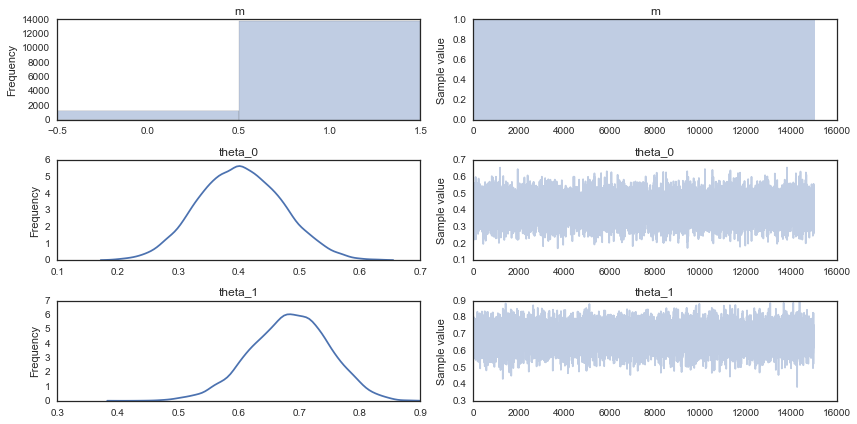

In [21]:
pmc.traceplot(trace4);

In [22]:
trace4_df = (pmc.trace_to_dataframe(trace4)
            .set_index('m')
            .iloc[:,:2])
trace4_df.head()

    theta_1   theta_0
m                    
1  0.717018  0.242834
1  0.717018  0.242834
1  0.699136  0.241966
1  0.664606  0.270715
1  0.747640  0.524214

In [23]:
# modes per category m
mode4_df = trace4_df.groupby(level=0).apply(lambda x: mode(np.round(x, decimals=3))[0][0])
mode4_df

m
0    [0.676, 0.368]
1    [0.699, 0.393]
dtype: object

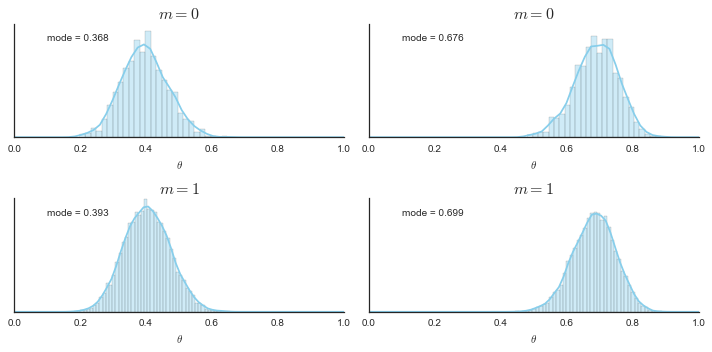

In [24]:
plt.figure(figsize=(10,5))

font_d = {'size':16}

# Define gridspec
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])

# Distplot theta0 when m = 0 (true prior)
sns.distplot(trace4_df.loc[0, 'theta_0'], ax = ax1, color=color)
ax1.set_title(r'$m = 0$', fontdict=font_d)
ax1.text(0.1, 0.85, 'mode = {}'.format(mode4_df.loc[0][1]), transform=ax1.transAxes)

# Distplot theta1 when m = 0 (pseudo prior)
sns.distplot(trace4_df.loc[0, 'theta_1'], ax = ax2, color=color)
ax2.set_title(r'$m = 0$', fontdict=font_d)
ax2.text(0.1, 0.85, 'mode = {}'.format(mode4_df.loc[0][0]), transform=ax2.transAxes)

# Distplot theta0 when m = 1 (pseudo prior)
sns.distplot(trace4_df.loc[1, 'theta_0'], ax = ax3, color=color)
ax3.set_title(r'$m = 1$', fontdict=font_d)
ax3.text(0.1, 0.85, 'mode = {}'.format(mode4_df.loc[1][1]), transform=ax3.transAxes)

# Distplot theta1 when m = 1 (true prior)
sns.distplot(trace4_df.loc[1, 'theta_1'], ax = ax4, color=color)
ax4.set_title(r'$m = 1$', fontdict=font_d)
ax4.text(0.1, 0.85, 'mode = {}'.format(mode4_df.loc[1][0]), transform=ax4.transAxes)

for ax in plt.gcf().axes:
    ax.set(xlim=(0,1), xlabel=r'$\theta$')
    ax.yaxis.set_visible(False)
    sns.despine(ax=ax)

plt.tight_layout();